# Read
The purpose of this Jupyter Notebook is to show results of our algorithm in the form of a deliverable. Though our algorithm is meant to be integrated into the Kiana system, we can show what our intentions are. Below you will find code ran on an entire day of data, that day being May 12th, 2018. You will then find a list of MacId's and thier scores. This list is a snipit of the list Kiana would have access to at any given time during the day. When the time metric is above 98%, they can choose to count both MacId's as the same person. In a potentially more impactful use case, if someone comes to security with a missing persons issue, they could give their phone to security. Security would then search the list to see if the phone had been matched frequntly with another device. They could then assume there is a high probability that device is the missing person and could use that information to quckly find out where the person has gone. 

The rest of this code is meant specifically for the purpose of displaying this result and can be ignored. The complete code for this algorithm has been submitted in a seperate file.

In [2]:
import pandas as pd
from os import listdir

data = pd.DataFrame()
for file in listdir():
    if 'master' in file:
        new_data = pd.read_csv(file)
        new_data = new_data.drop(['Unnamed: 0'], axis=1)
        data = data.append(new_data, ignore_index=True)

for i, val in enumerate(data['datetime']):
    this_time_str = val[:-4]
    data.at[i, 'datetime'] = pd.to_datetime(this_time_str, format='%Y-%m-%d %H:%M:%S.%f')

data = data.sort_values(['datetime']).reset_index(drop=True)

In [3]:
import math

day_data = data
day_data.head()

,floor,MacId,lat,lng,datetime
0,Level 1,36:b5:c6:75:9e:5f,1.291130,103.852005,2018-05-12 00:01:16
1,Level B1,16:4c:b0:9c:d2:54,1.289769,103.851310,2018-05-12 00:01:17
2,Level 1,b8:78:2e:e0:0a:3a,1.289633,103.850910,2018-05-12 00:01:17
3,Level 1,26:2e:19:27:da:e6,1.291126,103.852000,2018-05-12 00:01:17
4,Level 1,30:07:4d:13:03:bf,1.290005,103.851320,2018-05-12 00:01:17


In [4]:
import time
import itertools 

t0 = time.time()

time_step = '2 seconds'
initial_match_probability = 0.05
match_prob_growth_rate = 1.1
radius = 0.0000359 # about 4 meters

# first entry track of probabilities developed by growth rate
# second entry keeps track of number of times this match has occured
match_tracker = dict()

# keeps track of how many times this mac_id has shown up today
id_tracker = dict()

def remove_dup(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

# will catch KeyError when single days data has bee exhausted
try: 
    base_time = pd.to_datetime(day_data['datetime'][0])
    this_time = pd.to_datetime(day_data['datetime'][0])
    i = 0
    while True:
        current_buffer = dict()
        # this while loop loops through each Id found in current time buffer
        while this_time < base_time + pd.Timedelta(time_step):
            this_id = day_data['MacId'][i]
            
            # hash each macid based on location
            v1 = math.floor(data['lng'][i]/radius)
            v2 = math.floor(data['lat'][i]/radius)
            v3 = data['floor'][i]
            key = hash((v1, v2, v3))
            if key in current_buffer:
                current_buffer[key].append(this_id)
            else:
                current_buffer[key] = [this_id]
            
            # update mac tracker
            if this_id in id_tracker:
                id_tracker[this_id][0] += 1
                id_tracker[this_id][1].append((day_data['lat'][i], day_data['lng'][i]))
                id_tracker[this_id][2].append(day_data['datetime'][i])
            else:
                id_tracker[this_id] = []
                id_tracker[this_id].append(1)
                id_tracker[this_id].append([(day_data['lat'][i], day_data['lng'][i])])
                id_tracker[this_id].append([day_data['datetime'][i]])
            
            i += 1
            this_time = day_data['datetime'][i]
        
        # update probabilities with current buffer results
        for key in current_buffer:
            # remove duplicates
            matched_devices = remove_dup(current_buffer[key])
            # match made if hash table has multiple entries in one spot
            if (len(matched_devices) > 1) and (len(matched_devices) < 7):
                matched_devices = sorted(matched_devices) # always hash sorted list to find duplicates
                # consider all subsets of size 2
                all_subsets = list(itertools.combinations(range(len(matched_devices)), 2)) 
                for subset in all_subsets:
                    these_devices = [matched_devices[subset[0]], matched_devices[subset[1]]]
                    
                    match_hash = hash(tuple(these_devices))
                
                    # update or initialize this match
                    if match_hash in match_tracker:
                        match_tracker[match_hash][0] *= match_prob_growth_rate
                        match_tracker[match_hash][1] += 1
                        match_tracker[match_hash][2].append(base_time)
                    else:
                        match_tracker[match_hash] = [initial_match_probability, 1, [base_time], these_devices]
                    
                
        
        base_time = this_time
except KeyError:
    t1 = time.time()
    print('day completed')
    print('last time:', this_time)
    print('time ellapsed:', t1 - t0)
    

day completd
last time: 2018-05-12 23:56:59
time ellapsed: 835.2258379459381


The following code prints a list of MacId's as well as their time metric and adjusted time metric scores for matches made over 100 times on May 12th, 2018.

In [31]:
from sklearn import preprocessing
import numpy as np

df = pd.DataFrame()
counts = []
ids = []
adj_metrics = []
time_metrics = []
for key, match_list in match_tracker.items():
    counts.append(match_list[1])
    ids.append(match_list[3])

    time_metrics.append(match_time_metric(match_list[3][0], match_list[3][1]))
    adj_metrics.append(adj_time_metric(match_list[3][0], match_list[3][1]))


#df2['prob'] = probs
df['counts'] = counts
df['time metric'] = time_metrics
df['adj metric'] = adj_metrics
df['MacId'] = ids

df = df.sort_values(by=['counts', 'time metric', 'adj metric'], ascending=False).reset_index(drop=True)

for i in range(5000):
    if df.counts[i] > 100:
        print(df.MacId[i], 'time metric:', df['time metric'][i], 'adjusted metric:', df['adj metric'][i])

['44:00:10:ad:3f:73', '98:5a:eb:9b:0f:04'] time metric: 0.8277268093781855 adjusted metric: 0.05588171994574493
['94:e9:6a:3e:b3:c7', '94:e9:6a:47:f2:bc'] time metric: 0.9829351535836177 adjusted metric: 0.04206118218555665
['10:0b:a9:45:3c:b0', '48:4b:aa:0a:9a:64'] time metric: 0.5373831775700935 adjusted metric: 0.015380670874084663
['a8:6b:ad:12:c3:29', 'a8:6b:ad:13:01:b9'] time metric: 0.9119047619047619 adjusted metric: 0.02292244423901965
['0c:8b:fd:86:5a:dd', '18:5e:0f:6f:75:ca'] time metric: 0.19411296738265713 adjusted metric: 0.01117518522640513
['02:18:6a:a6:55:a0', '44:00:10:ad:3f:73'] time metric: 0.4004117344312918 adjusted metric: 0.00602971447404184
['10:0b:a9:65:81:24', 'c0:9f:05:85:96:10'] time metric: 0.9259574468085107 adjusted metric: 0.02277477908524095
['a4:31:35:90:d5:fe', 'd4:6a:6a:60:d3:b1'] time metric: 0.9595818815331011 adjusted metric: 0.008490996209167413
['18:5e:0f:16:d5:5a', '44:04:44:cb:8d:c8'] time metric: 0.9579579579579579 adjusted metric: 0.0156154

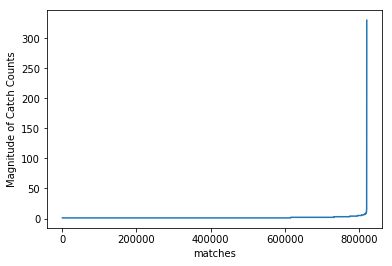

In [233]:
import matplotlib.pyplot as plt

plt.plot(range(df2.shape[0]), df2.counts)
plt.ylabel('Magnitude of Catch Counts')
plt.xlabel('matches')
plt.savefig('match_count_plt.png')
plt.show()
# this figure shows matched devices (x) vs the number of times they were matched (y)
# this graph shows us the algorithm is only catching a small number of devices a significant amount of times, which
# is a good sign

In [6]:
# this metric calcuates the cummulative amount of time spent in the museum by both devices over 2x the amount of 
# time matched

def match_time_metric(id1, id2):
    dev1_tot_time = (id_tracker[id1][2][-1].hour - id_tracker[id1][2][0].hour) * 60 + id_tracker[id1][2][-1].minute - id_tracker[id1][2][0].minute
    dev2_tot_time = (id_tracker[id2][2][-1].hour - id_tracker[id2][2][0].hour) * 60 + id_tracker[id2][2][-1].minute - id_tracker[id2][2][0].minute
    
    devs = sorted([id1, id2])
    time_matched = (match_tracker[hash(tuple(devs))][2][-1].hour - match_tracker[hash(tuple(devs))][2][0].hour) * 60 + match_tracker[hash(tuple(devs))][2][-1].minute - match_tracker[hash(tuple(devs))][2][0].minute
    try:
        score = (2 * time_matched) / (dev1_tot_time + dev2_tot_time)
    except ZeroDivisionError:
        score = -1
        
    return score

def adj_time_metric(id1, id2):
    dev1_tot_time = (id_tracker[id1][2][-1].hour - id_tracker[id1][2][0].hour) * 60 + id_tracker[id1][2][-1].minute - id_tracker[id1][2][0].minute
    dev2_tot_time = (id_tracker[id2][2][-1].hour - id_tracker[id2][2][0].hour) * 60 + id_tracker[id2][2][-1].minute - id_tracker[id2][2][0].minute
    
    devs = sorted([id1, id2])
    time_matched = (match_tracker[hash(tuple(devs))][2][-1].hour - match_tracker[hash(tuple(devs))][2][0].hour) * 60 + match_tracker[hash(tuple(devs))][2][-1].minute - match_tracker[hash(tuple(devs))][2][0].minute
    try:
        score = (2 * time_matched) / (dev1_tot_time + dev2_tot_time)
    except ZeroDivisionError:
        score = -1
        
    score = score*match_tracker[hash(tuple(devs))][1]/(id_tracker[id1][0] + id_tracker[id2][0])
        
    return score

In [30]:
def remove_dup(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 